In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
kappa = 0.125
# dtype = torch.complex128
dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
clover_term = clover.add_I(clover=clover_term)  # needed!

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
U_eo = xxxtzyx2pxxxtzyx(input_array=U)
clover_eo = xxxtzyx2pxxxtzyx(input_array=clover_term)


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support (when '#define _B

In [2]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U_eo=U_eo,
                clover=clover, clover_eo=clover_eo, verbose=True)

self.dof_list:[12, 8, 8, 4, 4, 2]
Building grid list:
  Level 0: 8x8x8x16
  Level 1: 4x4x4x8
  Level 2: 2x2x2x4
self.grid_list:[[16, 8, 8, 8], [8, 4, 4, 4], [4, 2, 2, 2]]

Performance Statistics:
Total iterations: 58
Total time: 0.648932 seconds
Average time per iteration: 0.011187 s
Final residual: 8.50e-04

Performance Statistics:
Total iterations: 58
Total time: 0.643879 seconds
Average time per iteration: 0.011100 s
Final residual: 9.01e-04

Performance Statistics:
Total iterations: 56
Total time: 0.656808 seconds
Average time per iteration: 0.011727 s
Final residual: 6.97e-04

Performance Statistics:
Total iterations: 55
Total time: 0.624913 seconds
Average time per iteration: 0.011361 s
Final residual: 9.94e-04

Performance Statistics:
Total iterations: 61
Total time: 0.666071 seconds
Average time per iteration: 0.010918 s
Final residual: 5.68e-04

Performance Statistics:
Total iterations: 56
Total time: 0.614464 seconds
Average time per iteration: 0.010971 s
Final residual: 5.69

In [3]:
_x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=True)

BICGSTAB:Iteration 0: Residual = 9.960020e+01, Time = 0.020439 s
BICGSTAB:Iteration 1: Residual = 4.786514e+01, Time = 0.012763 s
BICGSTAB:Iteration 2: Residual = 4.199868e+01, Time = 0.012491 s
BICGSTAB:Iteration 3: Residual = 2.587851e+01, Time = 0.012515 s
BICGSTAB:Iteration 4: Residual = 1.558178e+01, Time = 0.012375 s
BICGSTAB:Iteration 5: Residual = 1.132044e+01, Time = 0.012521 s
BICGSTAB:Iteration 6: Residual = 1.349335e+01, Time = 0.012384 s
BICGSTAB:Iteration 7: Residual = 1.347297e+01, Time = 0.014783 s
BICGSTAB:Iteration 8: Residual = 1.782291e+01, Time = 0.012579 s
BICGSTAB:Iteration 9: Residual = 2.040270e+01, Time = 0.011027 s
BICGSTAB:Iteration 10: Residual = 8.194285e+00, Time = 0.011183 s
BICGSTAB:Iteration 11: Residual = 8.926725e+00, Time = 0.011256 s
BICGSTAB:Iteration 12: Residual = 8.296926e+00, Time = 0.017223 s
BICGSTAB:Iteration 13: Residual = 9.088476e+00, Time = 0.014977 s
BICGSTAB:Iteration 14: Residual = 4.046773e+00, Time = 0.015777 s
BICGSTAB:Iteration 1

In [4]:
x = mg.solve()


MG:Iteration 1:
V-cycle level 0, mg_size: [16, 8, 8, 8]
    Pre pre-smooth residual norm: 3.5049e+02
    Pre-smoothing...

Performance Statistics:
Total iterations: 5
Total time: 0.073734 seconds
Average time per iteration: 0.014725 s
Final residual: 4.71e+00
    Post pre-smooth residual norm: 4.7104e+00
restrict:shape,coarse_dof:(torch.Size([8, 12, 8, 2, 4, 2, 4, 2, 4, 2]), 8)
EeTtZzYyXx,eTtZzYyXx->ETZYX
V-cycle level 1, mg_size: [8, 4, 4, 4]
    Pre pre-smooth residual norm: 2.7501e+00
    Pre-smoothing...

Performance Statistics:
Total iterations: 5
Total time: 0.013079 seconds
Average time per iteration: 0.002598 s
Final residual: 3.11e-01
    Post pre-smooth residual norm: 3.1142e-01
restrict:shape,coarse_dof:(torch.Size([8, 8, 4, 2, 2, 2, 2, 2, 2, 2]), 8)
EeTtZzYyXx,eTtZzYyXx->ETZYX
V-cycle level 2, mg_size: [4, 2, 2, 2]
    Pre-solve residual norm: 1.4686e-01
    Solving coarsest grid directly...

Performance Statistics:
Total iterations: 14
Total time: 0.035684 seconds
Average

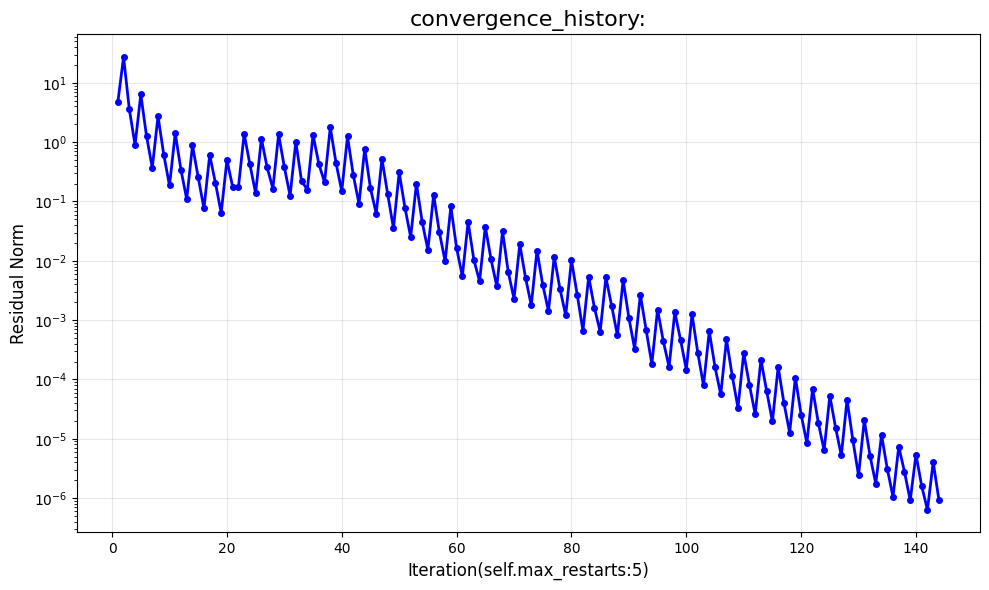

In [5]:
mg.plot()

In [6]:
b.reshape([12]+list(b.shape)[2:]).shape

torch.Size([12, 16, 8, 8, 8])